<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Rossman Sales Forecasting**

***Problem*** : Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied.

*Build a forecasting model to forecast the daily sales for the next six weeks*

In [296]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### **STORE DATA**

#### **Store Source Data**

In [297]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### **Store Data Processing**

In [298]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


####***Findings*** :
> The data type of CompetitionDistance, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear needs conversion to int.

> Competition and Promo data is unavailable for most of stores

> Promo2 (categorical) is already encoded to integer.




In [299]:
store = store.astype({
    'CompetitionOpenSinceMonth': pd.Int8Dtype(),
    'CompetitionOpenSinceYear': pd.Int16Dtype(),
    'Promo2SinceWeek': pd.Int8Dtype(),
    'Promo2SinceYear': pd.Int16Dtype()
})

In [300]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    Int8   
 5   CompetitionOpenSinceYear   761 non-null    Int16  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    Int8   
 8   Promo2SinceYear            571 non-null    Int16  
 9   PromoInterval              571 non-null    object 
dtypes: Int16(2), Int8(2), float64(1), int64(2), object(3)
memory usage: 63.3+ KB


In [301]:
#Check nulls for null treatment
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [302]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

#### ***Findings*** : When no Promo (Promo2 =0) then no Promo related details available in Promo2SinceWeek , Promo2SinceYear and PromoInterval

In [303]:
#NULL Treatment - we will set it as -1 to indicate there was no promotion.
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].replace(np.nan,-1).astype(int)
store['Promo2SinceYear'] = store['Promo2SinceYear'].replace(np.nan,-1).astype(int)


In [304]:
#CompetitionDistance - describes thedistance in meters to the nearest competitor store
store[store['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,<NA>,<NA>,0,-1,-1,NaN
621,622,a,c,NaN,<NA>,<NA>,0,-1,-1,NaN
878,879,d,a,NaN,<NA>,<NA>,1,5,2013,"Feb,May,Aug,Nov"


In [305]:
#Competition Distance and other competitor related fields values not available would indicate no competitor so can fill with -1
store['CompetitionDistance'] = store['CompetitionDistance'].replace(np.nan,-1).astype(int)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].replace(np.nan,-1).astype(int)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].replace(np.nan,-1).astype(int)

In [306]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,-1,-1,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,-1,-1,NaN
4,5,a,a,29910,4,2015,0,-1,-1,NaN


In [307]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

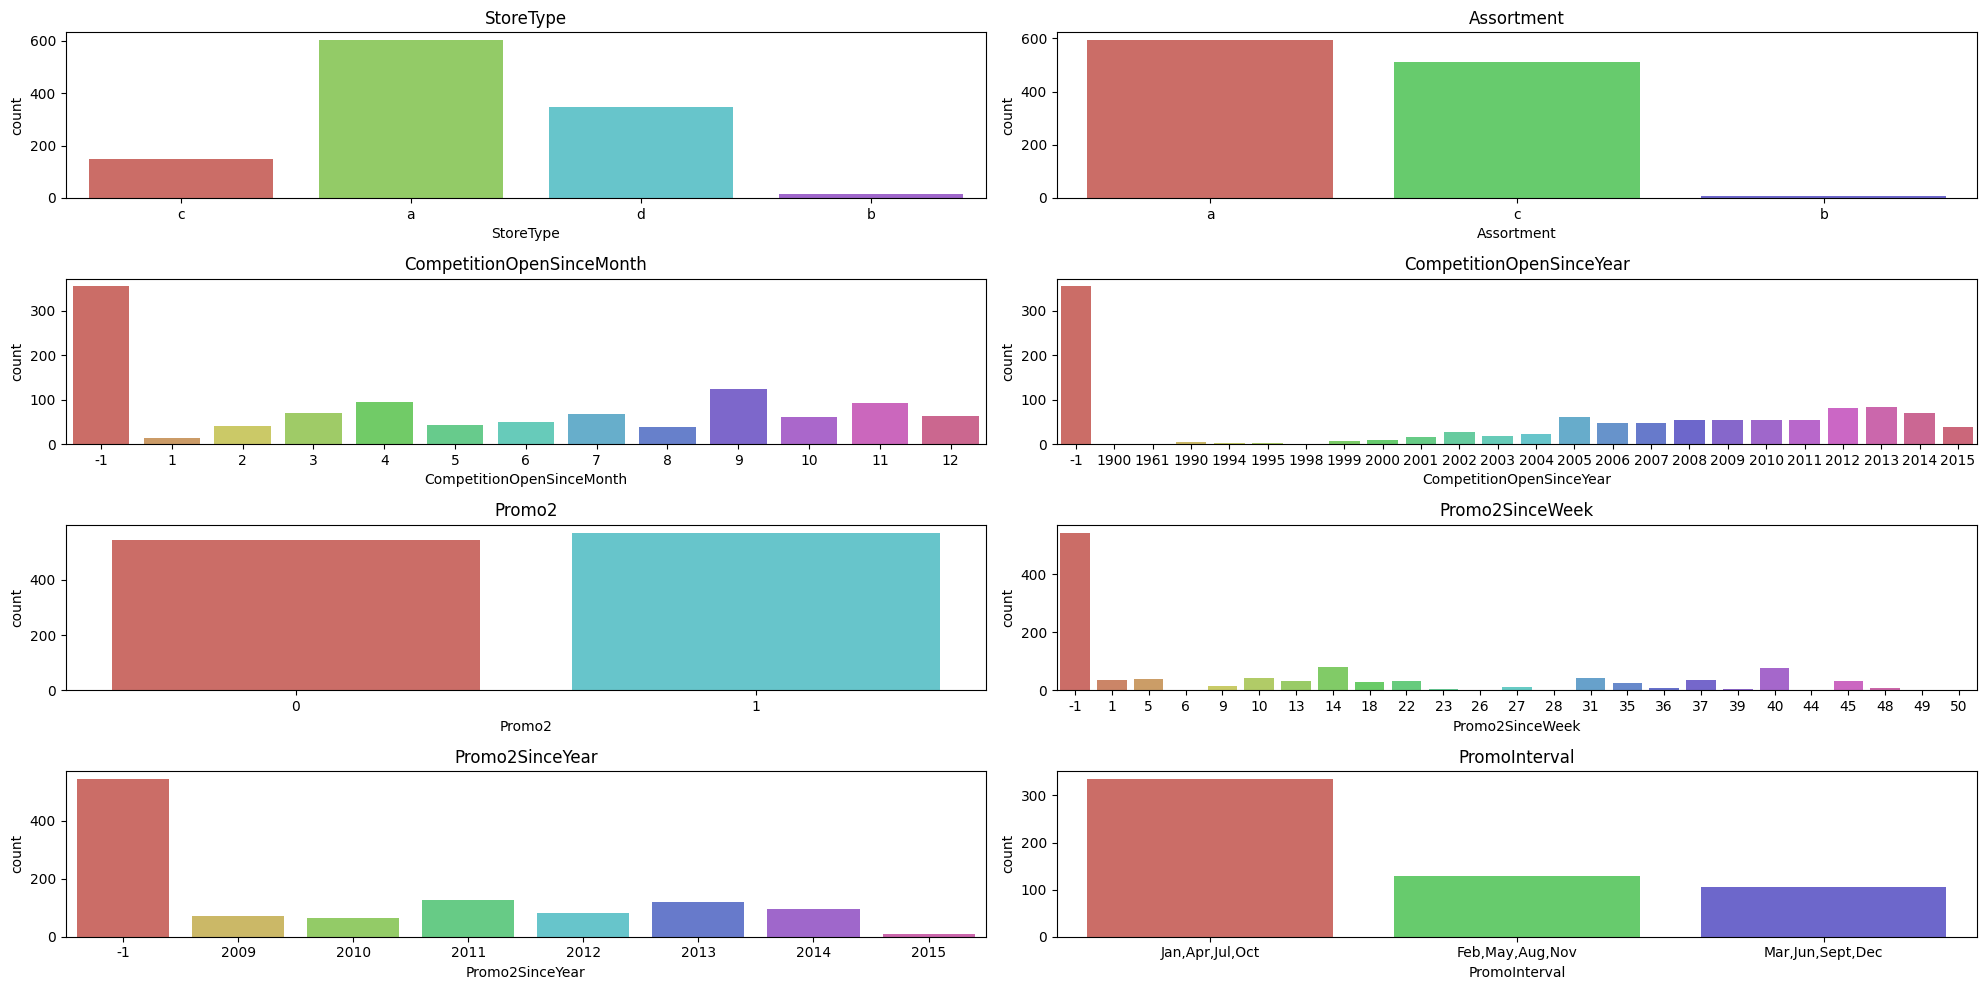

In [308]:
# Select categorical columns
categorical_cols = ['StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']#Excluding Store

# Define rows and columns for subplots
rows = int(np.ceil(len(categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=store, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**Inferences**
> Maximum competitions are opened in the month of september or 9

> Maximum competitiors opened their store in the year 2013

> 48% stores don't have promo2

> StoreType = a is maximum among others

> Majority of assortments are 'a'





In [309]:
sales_source = pd.read_csv('train.csv')
sales_source.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
filtered_store_sales = store_sales[
        (store_sales.Store == 1) | (store_sales.Store == 3)| (store_sales.Store == 8)| (store_sales.Store == 9)| (store_sales.Store == 13) |
        (store_sales.Store == 25) | (store_sales.Store == 29)| (store_sales.Store == 31)| (store_sales.Store == 46)
     ]

In [310]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [311]:
# Convert Date to a date-time-object
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d')

In [312]:
sales.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [315]:
sales.StateHoliday = sales.StateHoliday.replace(0,'N/A')

In [316]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [317]:
sales.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [318]:
sales_open = sales[sales.Open==1]
sales_open.shape

(844392, 9)

In [319]:
sales_open.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [320]:
sales_open.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

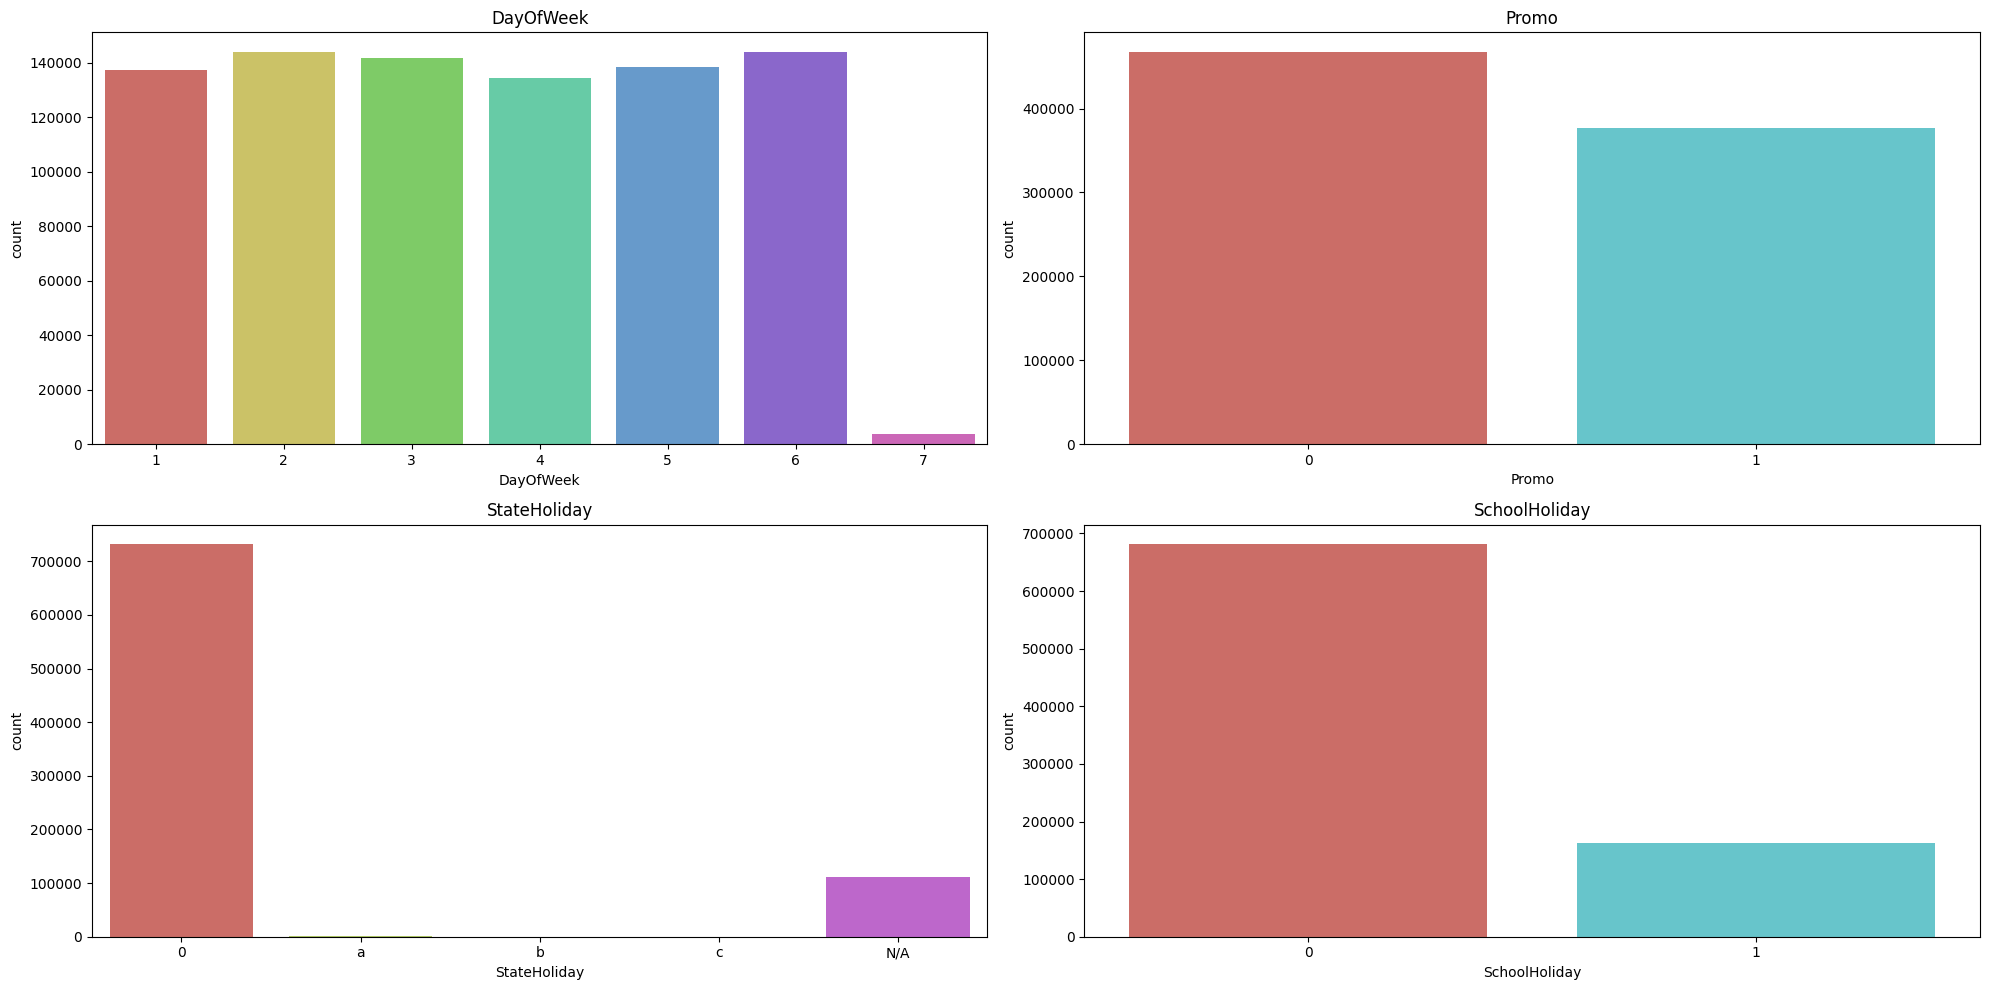

In [321]:
# Select categorical columns
sales_categorical_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']

# Define rows and columns for subplots
rows = int(np.ceil(len(sales_categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(sales_categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(sales_categorical_cols):
    sns.countplot(x=col, data=sales_open, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

**Inferences**
*   All days of the week have almost equal sales
*   Mostly the store is open
*   Promotions are less active

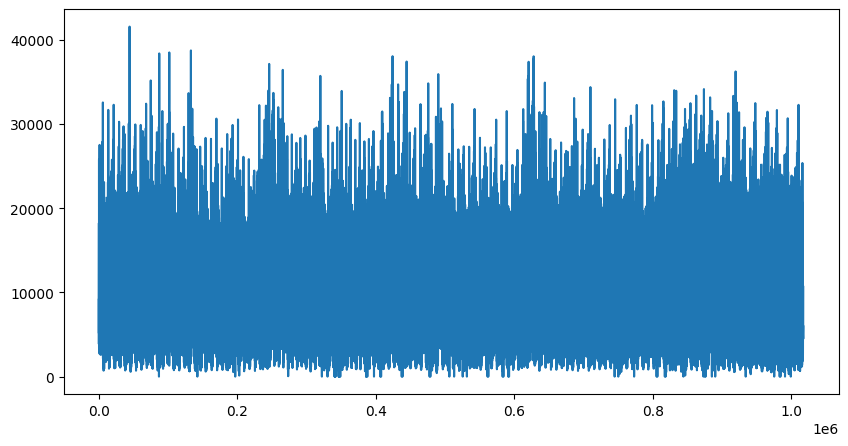

In [322]:
# sales plot
sales_open.Sales.plot(figsize=(10,5))
plt.show()

In [323]:
# detecting outliers
sales_open.describe(percentiles=[0.90,0.95,0.99])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000
90%,1004.000000,6.000000,10771.000000,1177.000000,1.0,1.000000,1.000000
95%,1060.000000,6.000000,12668.000000,1440.000000,1.0,1.000000,1.000000
99%,1104.000000,6.000000,17789.000000,2415.000000,1.0,1.000000,1.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000


In [324]:

# Calculate the 99th percentile of sales
sales_higher_threshold = sales_open.Sales.quantile(0.99)
cust_higher_threshold = sales_open.Customers.quantile(0.99)
# Filter the dataframe to remove outliers
sales_open = sales_open[((sales_open.Sales <= sales_higher_threshold) & (sales_open.Sales <= cust_higher_threshold)) ]

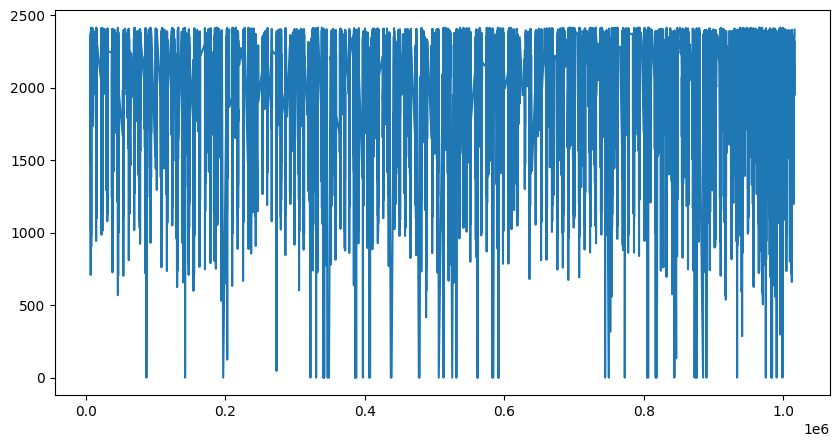

In [325]:
# sales plot
sales_open.Sales.plot(figsize=(10,5))
plt.show()

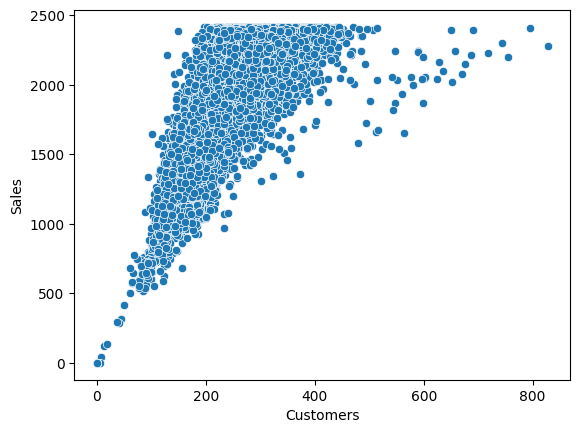

In [326]:
sns.scatterplot(x="Customers", y="Sales", data=sales_open)
plt.show()

In [327]:
# Check for ZERO values in Sales or Customer Values
count = (sales_open['Sales'] == 0).sum()
print('Number of zero values in Sales column:', count)

Number of zero values in Sales column: 54


In [328]:
# Check for ZERO values in Customer Values
count = (sales_open['Customers'] == 0).sum()
print('Number of zero values in Customers column:', count)

Number of zero values in Customers column: 52


In [329]:
# Check for null value rows and columns
missing = sales_open.isnull().sum()
missing.sort_values(ascending=False)

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [330]:
store_sales = sales.merge(right=store, on='Store', how='left')

In [331]:
store_sales.shape

(1017209, 18)

In [332]:
filtered_store_sales = store_sales[
        (store_sales.Store == 1) | (store_sales.Store == 3)| (store_sales.Store == 8)| (store_sales.Store == 9)| (store_sales.Store == 13) |
        (store_sales.Store == 25) | (store_sales.Store == 29)| (store_sales.Store == 31)| (store_sales.Store == 46)
     ]

In [333]:
# DELETE rows where Sales == 0 and Open == 0
# Open - an indicator for whether the store was open: 0 = closed, 1 = open
filtered_store_sales = filtered_store_sales[~((filtered_store_sales.Open==0) & (filtered_store_sales.Sales==0))]

In [334]:
# Now that we have filetred this let us see if there are any other anamolies
count = ((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0)).sum()
print(count)

2


In [335]:
filtered_store_sales[((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
561199,25,4,2014-02-13,0,0,1,0,N/A,0,c,a,430,4,2003,0,-1,-1,NaN
562314,25,3,2014-02-12,0,0,1,0,N/A,0,c,a,430,4,2003,0,-1,-1,NaN


In [336]:
# Update the above two rows's Sales and Customer to NaN and linear interpolate
filtered_store_sales.loc[((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0)), 'Sales'] = np.nan
filtered_store_sales.loc[((filtered_store_sales.Open==1) & (filtered_store_sales.Customers==0)), 'Customers'] = np.nan

In [337]:
filtered_store_sales.loc[((filtered_store_sales.Date=='2014-02-13') & (filtered_store_sales.Store==25))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
561199,25,4,2014-02-13,NaN,NaN,1,0,N/A,0,c,a,430,4,2003,0,-1,-1,NaN


In [338]:
filtered_store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6681 entries, 0 to 1015025
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      6681 non-null   int64         
 1   DayOfWeek                  6681 non-null   int64         
 2   Date                       6681 non-null   datetime64[ns]
 3   Sales                      6679 non-null   float64       
 4   Customers                  6679 non-null   float64       
 5   Open                       6681 non-null   int64         
 6   Promo                      6681 non-null   int64         
 7   StateHoliday               6681 non-null   object        
 8   SchoolHoliday              6681 non-null   int64         
 9   StoreType                  6681 non-null   object        
 10  Assortment                 6681 non-null   object        
 11  CompetitionDistance        6681 non-null   int64         
 12  Com

In [339]:
filtered_df = filtered_store_sales#.set_index('Date')
#Extracting some date features for analysis for all stores.
filtered_df['Year'] = filtered_df['Date'].dt.year
filtered_df['Month'] = filtered_df['Date'].dt.month
filtered_df['Day'] = filtered_df['Date'].dt.day
filtered_df['WeekOfYear'] = filtered_df['Date'].dt.weekofyear

Only nine stores have to be considered so let us filter those.
Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46

In [340]:
data_store1 = filtered_df[(filtered_df.Store==1)]
print('Number of records for store 1: ', len(data_store1))
data_store3 = filtered_df[(filtered_df.Store==3)]
print('Number of records for store 3: ', len(data_store3))
data_store8 = filtered_df[(filtered_df.Store==8)]
print('Number of records for store 8: ', len(data_store8))
data_store9 = filtered_df[(filtered_df.Store==9)]
print('Number of records for store 9: ', len(data_store9))
#
data_store13 = filtered_df[(filtered_df.Store==13)]
print('Number of records for store 13: ', len(data_store13))
data_store25 = filtered_df[(filtered_df.Store==25)]
print('Number of records for store 25: ', len(data_store25))
data_store29 = filtered_df[(filtered_df.Store==29)]
print('Number of records for store 29: ', len(data_store29))
data_store31 = filtered_df[(filtered_df.Store==31)]
print('Number of records for store 31: ', len(data_store31))
#
data_store46 = filtered_df[(filtered_df.Store==46)]
print('Number of records for store 46: ', len(data_store46))

Number of records for store 1:  781
Number of records for store 3:  779
Number of records for store 8:  784
Number of records for store 9:  779
Number of records for store 13:  621
Number of records for store 25:  752
Number of records for store 29:  779
Number of records for store 31:  784
Number of records for store 46:  622


In [341]:
def plot_store_trend(title, xaxis, yaxis, chart_type,order_list =None):

  left  = 0.125  # the left side of the subplots of the figure
  right = 0.9    # the right side of the subplots of the figure
  bottom = 0.1   # the bottom of the subplots of the figure
  top = 0.9      # the top of the subplots of the figure
  wspace = 0.2   # the amount of width reserved for blank space between subplots
  hspace = 0.8   # the amount of height reserved for white space between subplots

  store_dfs = [data_store1, data_store3, data_store8, data_store9, data_store13, data_store25, data_store29, data_store31, data_store46 ]
  label_dfs = ['store1', 'store3', 'store8', 'store9', 'store13', 'store25','store29', 'store31', 'store46']
  index = [1,3,8,9,13,25,29,31,46]

  # PROMO
  fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10,6))
  fig.suptitle(title)
  fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

  i = 0
  for x in range (0,3):
      for y in range (0,3):
          #i = x + y + int(incr)
          j = index[i]
          label =  label_dfs[i]
          d = store_dfs[i]
          axis[x,y].title.set_text(label)
          if chart_type == 'bar':
            if order_list is None:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="hls")
            else:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], order = order_list, palette="hls")

          if chart_type == 'line':
              sns.lineplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="hls")
          elif chart_type == 'box':
              sns.boxplot(x=d[xaxis],whis=1.5, palette="hls")
          i = i + 1

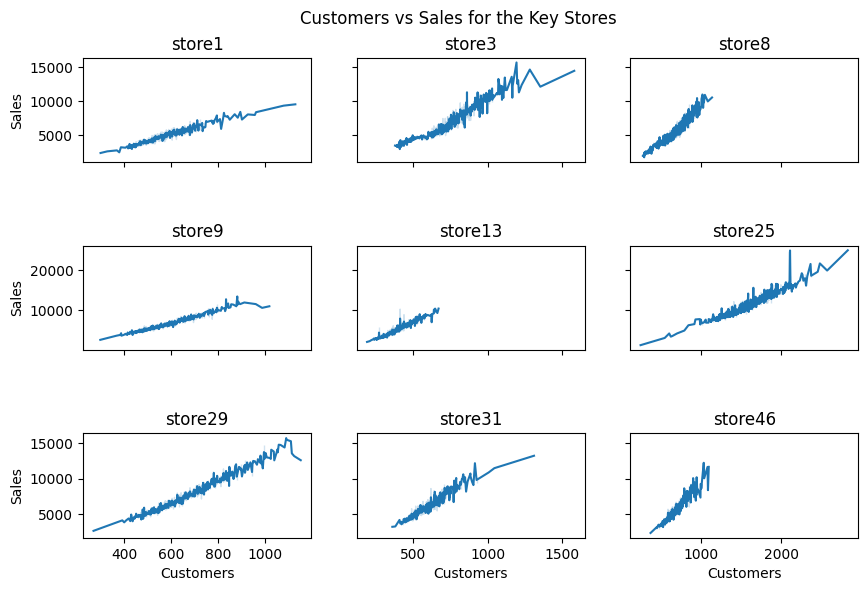

In [342]:
plot_store_trend('Customers vs Sales for the Key Stores', 'Customers', 'Sales', 'line')

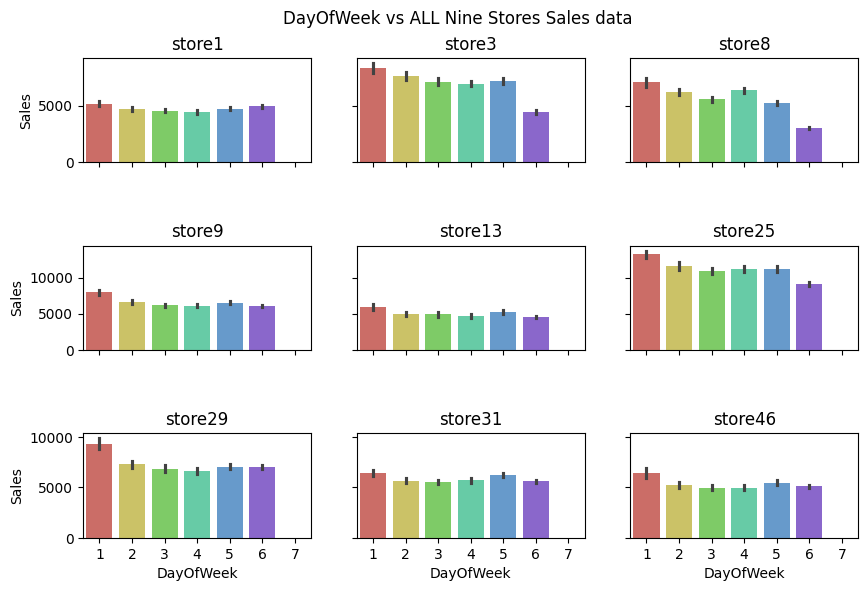

In [343]:
plot_store_trend('DayOfWeek vs ALL Nine Stores Sales data', 'DayOfWeek', 'Sales', 'bar',[1,2,3,4,5,6,7])

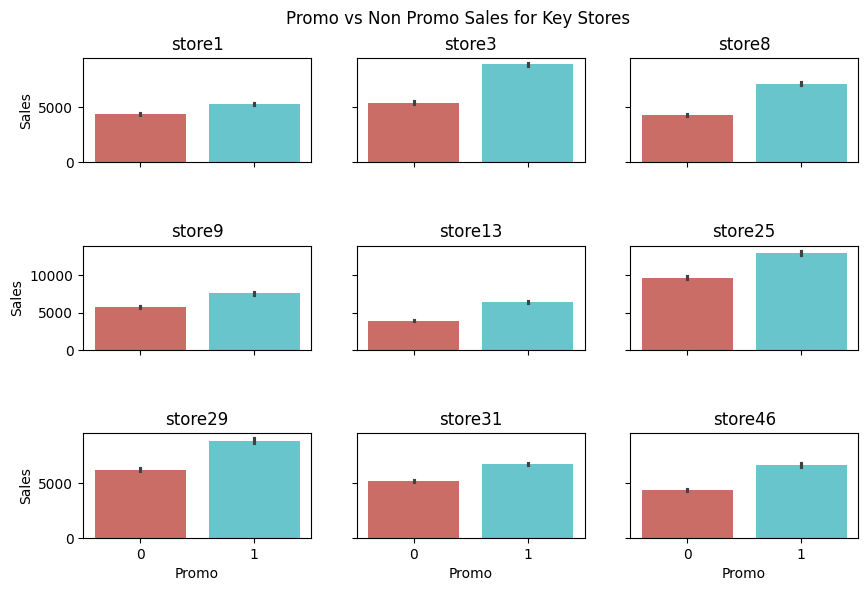

In [344]:
plot_store_trend('Promo vs Non Promo Sales for Key Stores', 'Promo', 'Sales', 'bar')

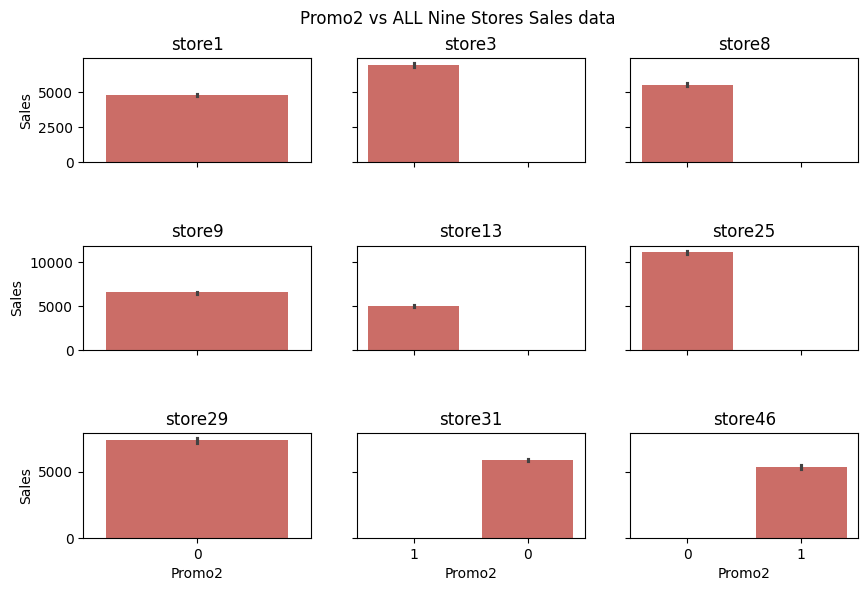

In [345]:
plot_store_trend('Promo2 vs ALL Nine Stores Sales data', 'Promo2', 'Sales', 'bar')

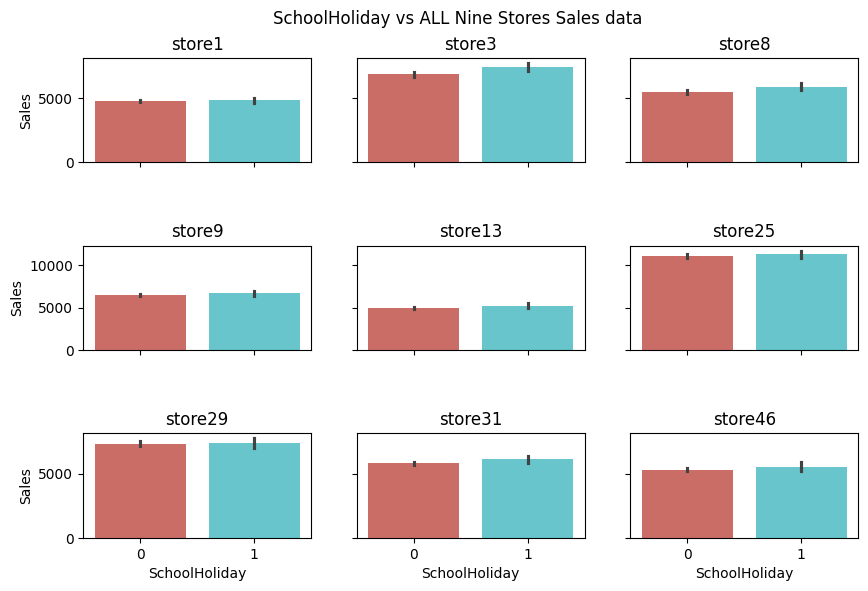

In [346]:
plot_store_trend('SchoolHoliday vs ALL Nine Stores Sales data', 'SchoolHoliday', 'Sales', 'bar')

In [347]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6681 entries, 0 to 1015025
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      6681 non-null   int64         
 1   DayOfWeek                  6681 non-null   int64         
 2   Date                       6681 non-null   datetime64[ns]
 3   Sales                      6679 non-null   float64       
 4   Customers                  6679 non-null   float64       
 5   Open                       6681 non-null   int64         
 6   Promo                      6681 non-null   int64         
 7   StateHoliday               6681 non-null   object        
 8   SchoolHoliday              6681 non-null   int64         
 9   StoreType                  6681 non-null   object        
 10  Assortment                 6681 non-null   object        
 11  CompetitionDistance        6681 non-null   int64         
 12  Com

In [348]:
filtered_df.StateHoliday = filtered_df.StateHoliday.replace(0,'N/A')

In [349]:
#filtered_df = filtered_df.reset_index()


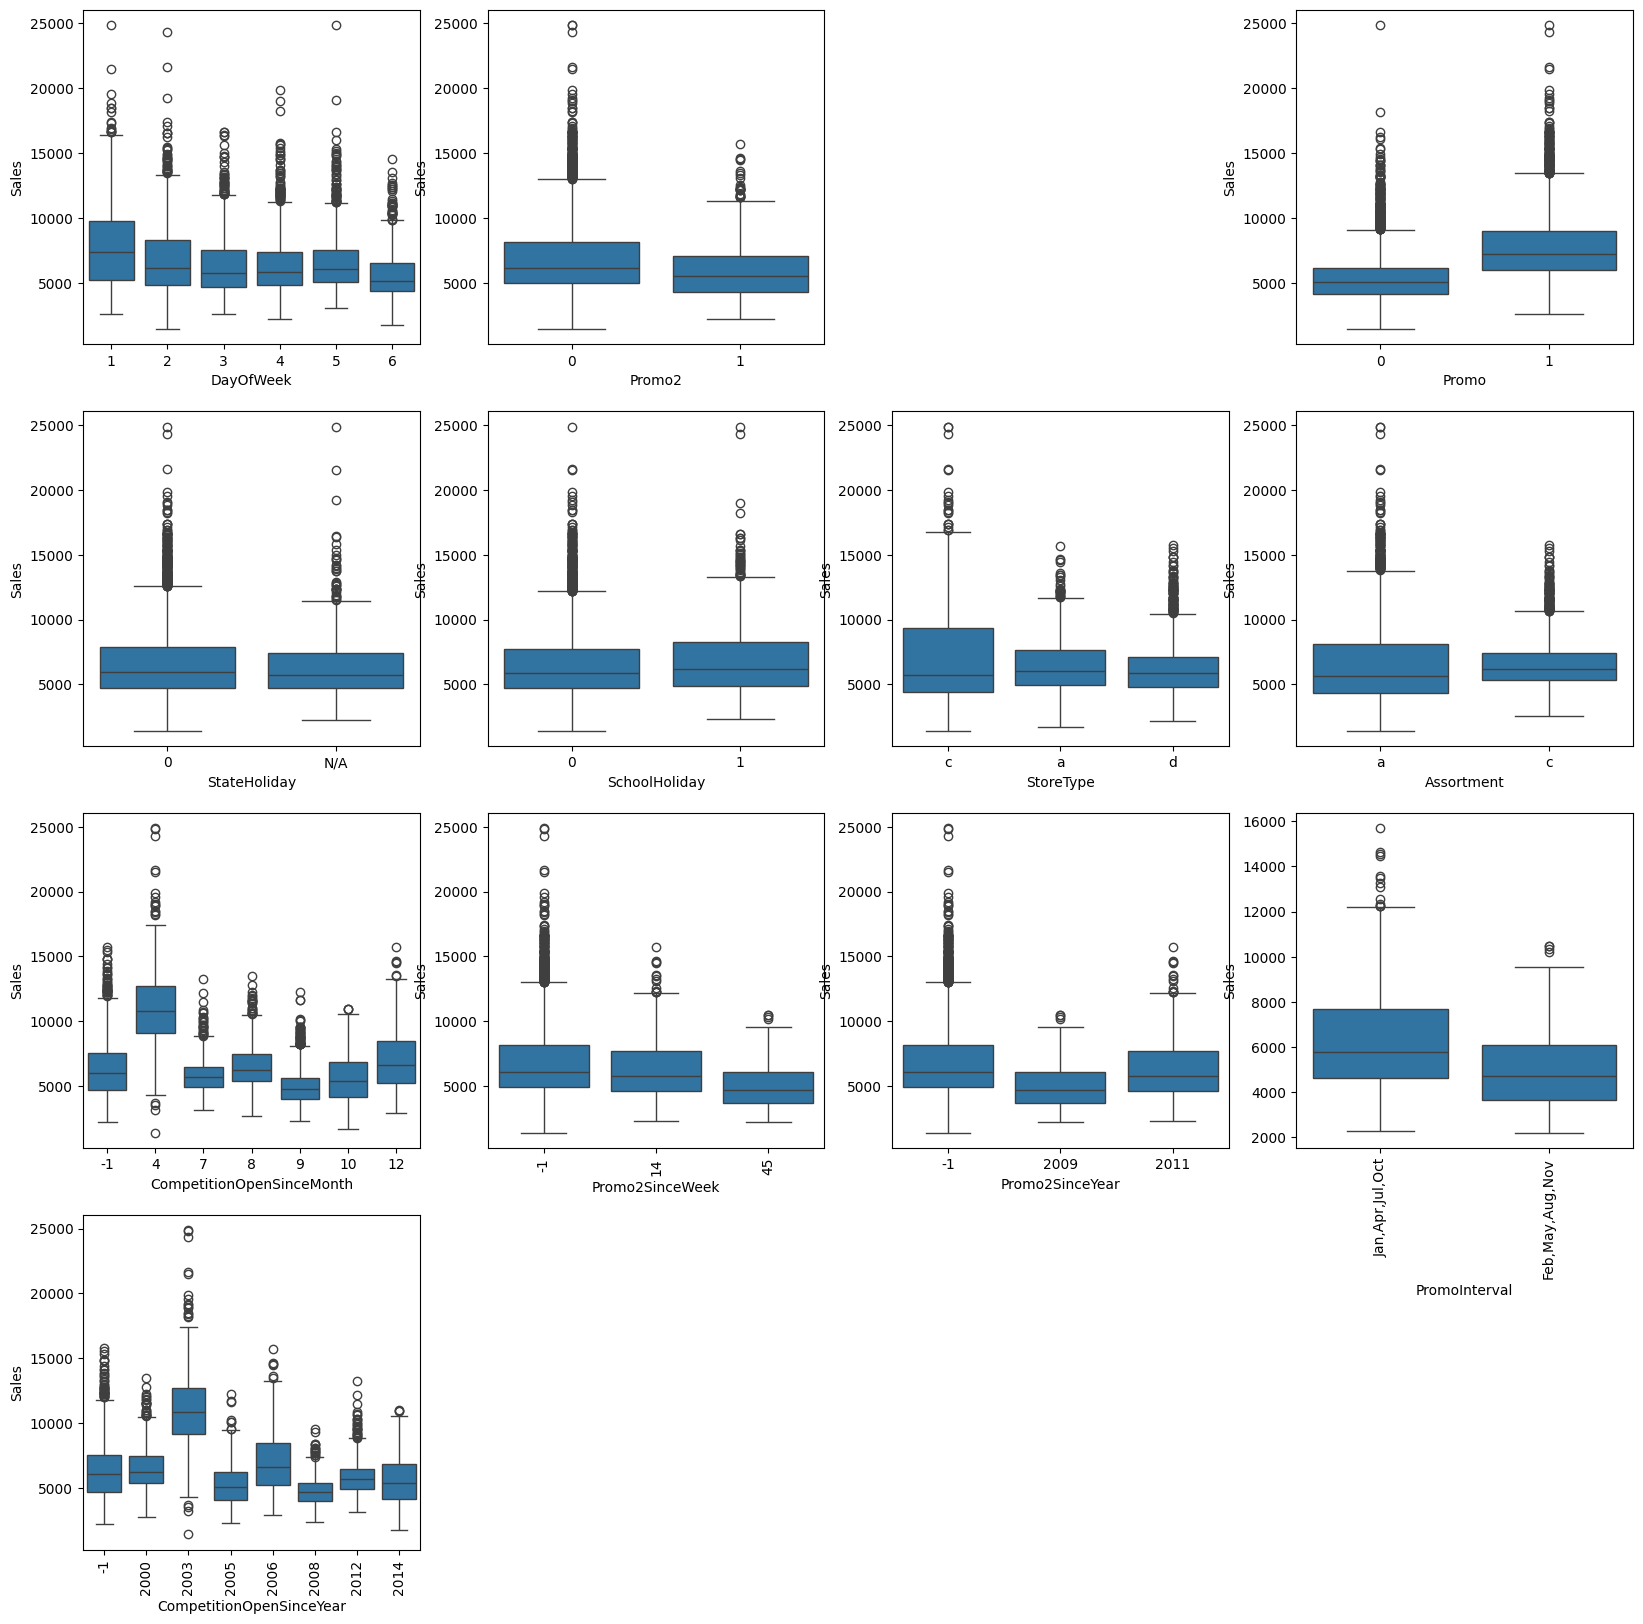

In [350]:
# box-plot creation for variious variables w.r.t sales
plt.figure(figsize=(20,20))
plt.subplot(4,4,1)
sns.boxplot(x = filtered_df.DayOfWeek, y = filtered_df.Sales)

plt.subplot(4,4,2)
sns.boxplot(x = filtered_df.Promo2, y = filtered_df.Sales)

plt.subplot(4,4,4)
sns.boxplot(x = filtered_df.Promo, y = filtered_df.Sales)

plt.subplot(4,4,5)
sns.boxplot(x = filtered_df.StateHoliday, y = filtered_df.Sales)

plt.subplot(4,4,6)
sns.boxplot(x = filtered_df.SchoolHoliday, y = filtered_df.Sales)

plt.subplot(4,4,7)
sns.boxplot(x = filtered_df.StoreType, y = filtered_df.Sales)

plt.subplot(4,4,8)
sns.boxplot(x = filtered_df.Assortment, y = filtered_df.Sales)

plt.subplot(4,4,9)
sns.boxplot(x = filtered_df.CompetitionOpenSinceMonth, y = filtered_df.Sales)

plt.subplot(4,4,10)
sns.boxplot(x = filtered_df.Promo2SinceWeek, y = filtered_df.Sales)
plt.xticks(rotation=90)

plt.subplot(4,4,11)
sns.boxplot(x = filtered_df.Promo2SinceYear, y = filtered_df.Sales)

plt.subplot(4,4,12)
sns.boxplot(x = filtered_df.PromoInterval, y = filtered_df.Sales)
plt.xticks(rotation=90)

plt.subplot(4,4,13)
sns.boxplot(x = filtered_df.CompetitionOpenSinceYear, y = filtered_df.Sales)

plt.xticks(rotation=90)
plt.show()

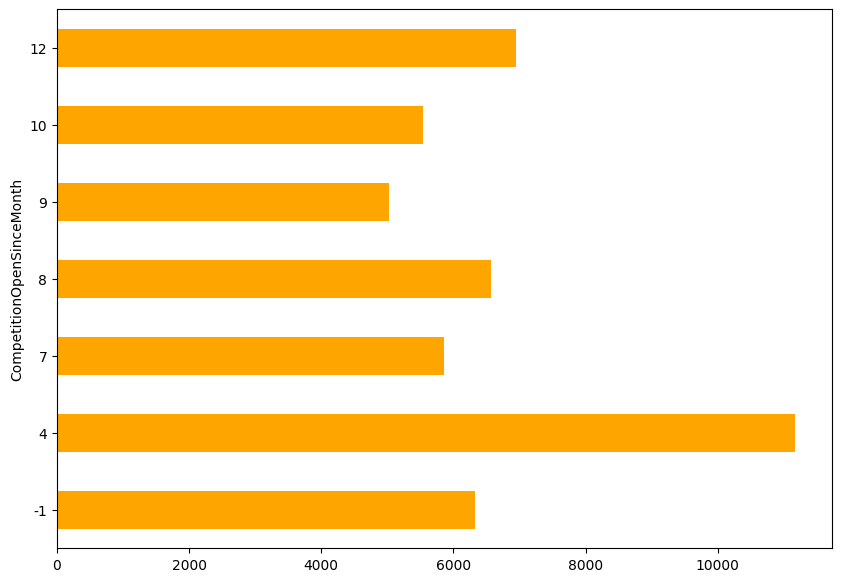

In [351]:
# trend/seasonality search
filtered_df.groupby(['CompetitionOpenSinceMonth'])['Sales'].mean().plot.barh(figsize=(10,7), color='orange')
plt.show()

<Axes: xlabel='CompetitionOpenSinceYear', ylabel='Density'>

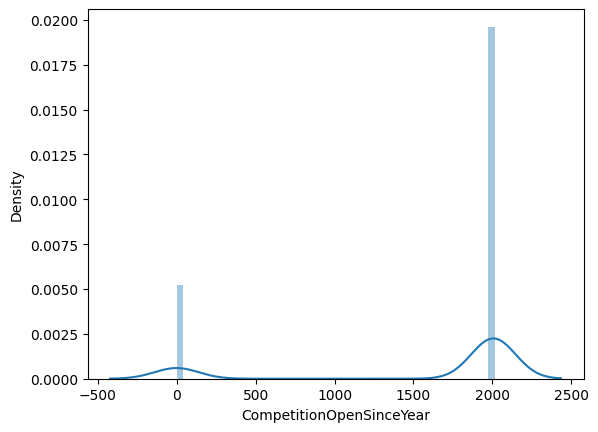

In [352]:
sns.distplot(filtered_df['CompetitionOpenSinceYear'])

<Axes: xlabel='CompetitionOpenSinceMonth', ylabel='Density'>

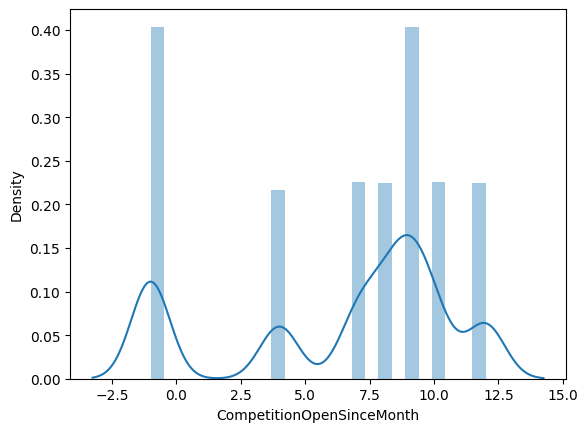

In [353]:
sns.distplot(filtered_df['CompetitionOpenSinceMonth'])

Text(0.5, 0, 'Competition Distance in meters')

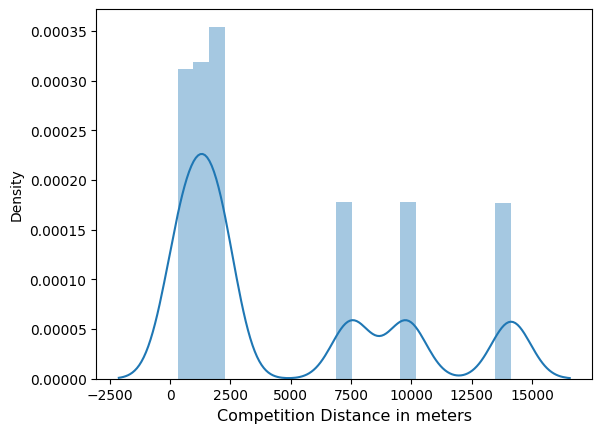

In [354]:
#Plotting distribution of Competition Distance.
sns.distplot(filtered_df['CompetitionDistance'])
plt.xlabel('Competition Distance in meters',fontsize=11.5)

In [355]:
filtered_df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,2342.0,6346.361657,2008.043751,1725.0,4977.25,6051.5,7664.5,15689.0
c,2153.0,7163.277288,3531.526947,1410.0,4407.00,5735.0,9346.0,24882.0
d,2184.0,6162.949176,2005.842984,2210.0,4811.75,5872.5,7081.5,15758.0


In [356]:
avg_sales__avg_customers = filtered_df.groupby('Store').mean()[['Sales', 'Customers']]
sns.scatterplot('Customers', 'Sales', data=avg_sales__avg_customers)
plt.show()

TypeError: scatterplot() got multiple values for argument 'data'

In [ ]:
display(Markdown(f"Pearson cofficient is `{'%.2f' % filtered_df[['Sales', 'Customers']].corr().iloc[0,1]}`"))